In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

In [2]:
# Scikit-learn pour le ML
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
# Modèles
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

>>> 1. CHARGEMENT DES DONNÉES
Using Colab cache for faster access to the 'dataset-phishing-domain-detection-cybersecurity' dataset.
Chemin du dataset : /kaggle/input/dataset-phishing-domain-detection-cybersecurity
Fichier chargé : dataset_cybersecurity_michelle.csv
Dimensions : (129698, 112)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129698 entries, 0 to 129697
Columns: 112 entries, qty_dot_url to phishing
dtypes: float64(1), int64(111)
memory usage: 110.8 MB
None

>>> 2. PRÉ-TRAITEMENT
Doublons supprimés : 42489
Variable cible identifiée : phishing

>>> 3. ANALYSE EXPLORATOIRE (EDA)


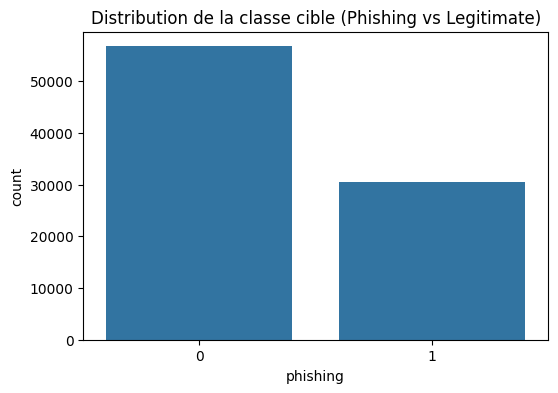

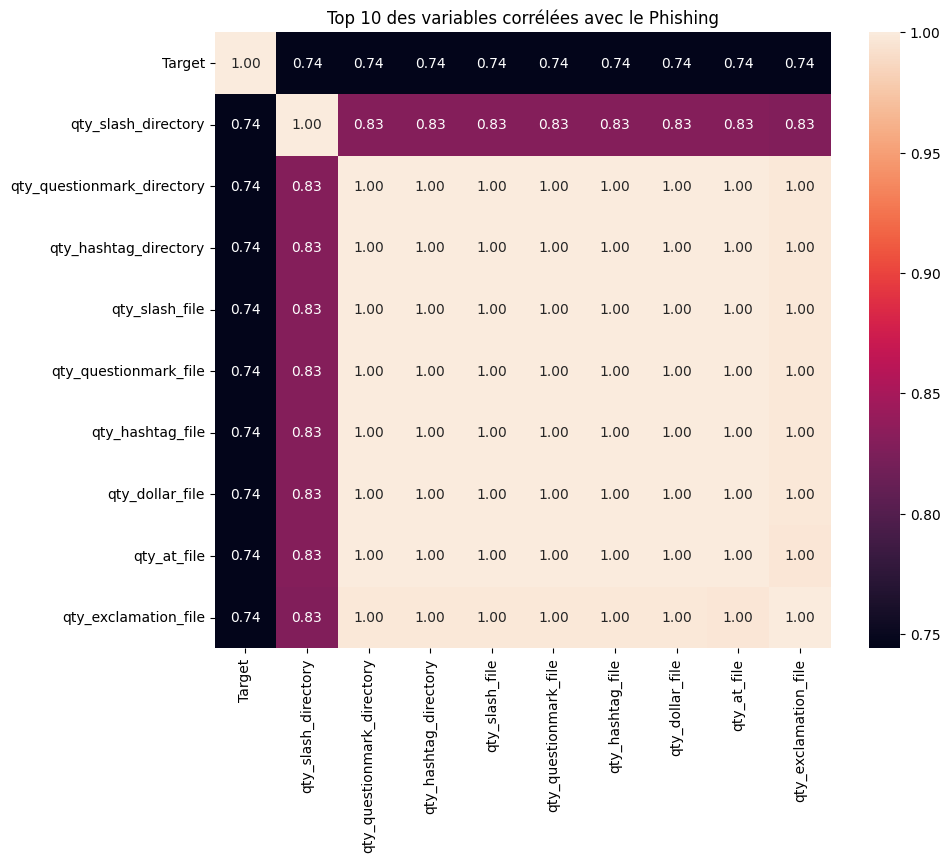


>>> 4. MODÉLISATION (3 Algorithmes)

--- Entraînement : Logistic Regression ---
Accuracy : 0.9318
ROC-AUC  : 0.9275
              precision    recall  f1-score   support

           0       0.95      0.94      0.95     11343
           1       0.89      0.91      0.90      6099

    accuracy                           0.93     17442
   macro avg       0.92      0.93      0.93     17442
weighted avg       0.93      0.93      0.93     17442


--- Entraînement : Random Forest ---
Accuracy : 0.9688
ROC-AUC  : 0.9667
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     11343
           1       0.95      0.96      0.96      6099

    accuracy                           0.97     17442
   macro avg       0.96      0.97      0.97     17442
weighted avg       0.97      0.97      0.97     17442



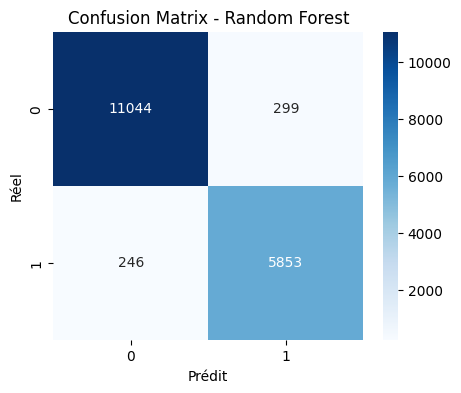


--- Entraînement : Gradient Boosting ---
Accuracy : 0.9532
ROC-AUC  : 0.9487
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     11343
           1       0.93      0.93      0.93      6099

    accuracy                           0.95     17442
   macro avg       0.95      0.95      0.95     17442
weighted avg       0.95      0.95      0.95     17442


>>> 5. OPTIMISATION DES HYPERPARAMÈTRES (Random Forest)
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Meilleurs paramètres : {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy après optimisation : 0.9690

>>> ANALYSE TERMINÉE
Le modèle le plus performant est : Random Forest avec 96.88% d'accuracy.


In [3]:
# --- 1. CHARGEMENT DES DONNÉES ---
print(">>> 1. CHARGEMENT DES DONNÉES")
# Téléchargement via l'API
path = kagglehub.dataset_download("michellevp/dataset-phishing-domain-detection-cybersecurity")
print(f"Chemin du dataset : {path}")


# Kagglehub télécharge souvent dans un dossier, on cherche le fichier .csv dedans
import os
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
if csv_files:
    file_path = os.path.join(path, csv_files[0])
    df = pd.read_csv(file_path)
    print(f"Fichier chargé : {csv_files[0]}")
else:
    raise FileNotFoundError("Aucun fichier CSV trouvé dans le dossier téléchargé.")

# Affichage des premières infos
print(f"Dimensions : {df.shape}")
print(df.info())

# --- 2. PRÉ-TRAITEMENT (PREPROCESSING) ---
print("\n>>> 2. PRÉ-TRAITEMENT")

# a. Nettoyage (Doublons)
initial_rows = df.shape[0]
df = df.drop_duplicates()
print(f"Doublons supprimés : {initial_rows - df.shape[0]}")

# b. Gestion de la Target et des variables inutiles
# Dans ce dataset, la colonne 'url' est du texte brut (souvent inutile si on a déjà les features calculées)
# La target est souvent nommée 'phishing' ou 'status'. On vérifie :
target_col = 'phishing' if 'phishing' in df.columns else df.columns[-1] # On suppose la dernière si non trouvée
print(f"Variable cible identifiée : {target_col}")

# Si la target est textuelle (ex: 'legitimate', 'phishing'), on l'encode
if df[target_col].dtype == 'object':
    le = LabelEncoder()
    df[target_col] = le.fit_transform(df[target_col])
    print(f"Encodage de la target : {le.classes_}")

# Suppression de la colonne URL brute si elle existe (car on analyse les features numériques)
if 'url' in df.columns:
    df = df.drop(columns=['url'])

# c. Séparation Features (X) / Target (y)
X = df.drop(columns=[target_col])
y = df[target_col]

# d. Imputation (Valeurs manquantes) - Stratégie médiane
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# e. Normalisation (StandardScaler)
# Essentiel pour la Régression Logistique et les algo basés sur la distance
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

# Split Train/Test (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# --- 3. ANALYSE EXPLORATOIRE (EDA) ---
print("\n>>> 3. ANALYSE EXPLORATOIRE (EDA)")

# Visualisation de l'équilibre des classes
plt.figure(figsize=(6, 4))
sns.countplot(x=target_col, data=df)
plt.title("Distribution de la classe cible (Phishing vs Legitimate)")
plt.show()

# Matrice de corrélation (Top 10 features les plus corrélées à la cible)
# On reconstruit un df temporaire pour la corrélation
df_corr = X_scaled.copy()
df_corr['Target'] = y.reset_index(drop=True)
corr = df_corr.corr()

plt.figure(figsize=(10, 8))
# On affiche la heatmap des correlations avec la Target
k = 10 # nombre de variables
cols = corr.nlargest(k, 'Target')['Target'].index
cm = np.corrcoef(df_corr[cols].values.T)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.title("Top 10 des variables corrélées avec le Phishing")
plt.show()

# --- 4. MODÉLISATION & COMPARAISON ---
print("\n>>> 4. MODÉLISATION (3 Algorithmes)")

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\n--- Entraînement : {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Métriques
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    results[name] = acc

    print(f"Accuracy : {acc:.4f}")
    print(f"ROC-AUC  : {roc:.4f}")
    print(classification_report(y_test, y_pred))

    # Matrice de confusion pour le meilleur modèle (souvent RF ou GB)
    if name == "Random Forest":
        plt.figure(figsize=(5, 4))
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
        plt.title(f"Confusion Matrix - {name}")
        plt.ylabel('Réel')
        plt.xlabel('Prédit')
        plt.show()

# --- 5. OPTIMISATION (GridSearchCV) ---
print("\n>>> 5. OPTIMISATION DES HYPERPARAMÈTRES (Random Forest)")
# On optimise le Random Forest qui est souvent le plus performant
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=3, # Cross-Validation à 3 plis
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train, y_train)

print(f"Meilleurs paramètres : {grid_search.best_params_}")
best_model = grid_search.best_estimator_
y_pred_opt = best_model.predict(X_test)
print(f"Accuracy après optimisation : {accuracy_score(y_test, y_pred_opt):.4f}")

# --- CONCLUSION ---
print("\n>>> ANALYSE TERMINÉE")
best_algo = max(results, key=results.get)
print(f"Le modèle le plus performant est : {best_algo} avec {results[best_algo]:.2%} d'accuracy.")